In [52]:
import math
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import stats, integrate
import pandas as pd
import pytz
import datetime as dt

In [7]:
import biosppy
from biosppy import storage
from biosppy.signals import ecg

## Example of ECG signal visualization with biospy 

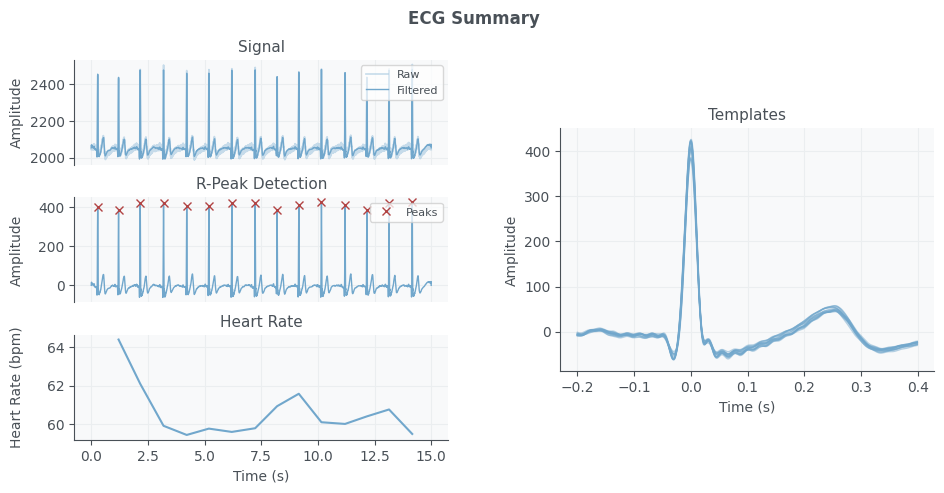

In [8]:
#ecg_example = "C:/Users/muhammad.saif/Desktop/repos_ixp/BioSPPy/examples/ecg.txt"

ecg_example = "/home/muhammad/Desktop/repos_ixp/BioSPPy/examples/ecg.txt"
# load raw ECG signal
signal, mdata = storage.load_txt(ecg_example)
out = ecg.ecg(signal=signal, sampling_rate=1000., show=True,interactive=False)

## Read and manipulate psychopy and shimmer files 

In [9]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    

## Time Domain HRV

In [102]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

## Paths  and inputs

In [38]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]


In [239]:

psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"
ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

#col_interest_psychopy = "tsst_prep_ts"

In [286]:
event_interest = event_interest_list_new[1]
#ä offset time in mins
time_offset = 5


In [287]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest_list_new[0])
start_timestamp = non_nan_timestamp[0]



stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)


In [288]:
print(start_timestamp)
print(stop_timestamp)

1699449492.5466542
1699449792.546654


In [289]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print(start_time)
print(end_time)

2023-11-08 14:18:12.546654+01:00
2023-11-08 14:23:12.546654+01:00


In [290]:
ecg_df = read_shimmer_sensor(ecg_file_path)

In [291]:
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)


In [292]:
sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

In [293]:
sliced_ecg_df

0      Shimmer_6B1E_Timestamp_Unix_CAL Shimmer_6B1E_ECG_LA-RA_24BIT_CAL
0                         1.699449e+09                78.57175452372486
1                         1.699449e+09                78.57478363213345
2                         1.699449e+09                78.57319695630038
3                         1.699449e+09                78.58127457872327
4                         1.699449e+09                78.57355756444426
...                                ...                              ...
76690                     1.699450e+09                75.36630873278484
76691                     1.699450e+09                75.37914638270694
76692                     1.699450e+09                75.35794262384685
76693                     1.699450e+09                75.32505516112509
76694                     1.699450e+09                75.33327702680553

[76695 rows x 2 columns]

In [294]:
start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print(start_time_hr)
print(end_time_hr)

2023-11-08 14:18:12.549255+01:00
2023-11-08 14:23:12.545349+01:00


In [295]:
sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

In [296]:
ecg_array = sliced_ecg_df["heartrate"].values

In [297]:
out = ecg.ecg(signal=ecg_array, sampling_rate=256, show=False,interactive=False)

In [298]:
sliced_ecg_df["filtered"] = out["filtered"]

In [299]:
r_peaks = out["rpeaks"]

In [300]:
r_peaks_selected = [r_p for r_p in r_peaks if r_p >= 236 and r_p <= 1410]

In [301]:
len(r_peaks_selected)

6

In [302]:
starting_index_slcide_df= sliced_ecg_df.index[0]
sampfrom = starting_index_slcide_df
sampto = starting_index_slcide_df+256*time_offset*60
nr_plots = 5

0
15360
15360
30720
30720
46080
46080
61440
61440
76800


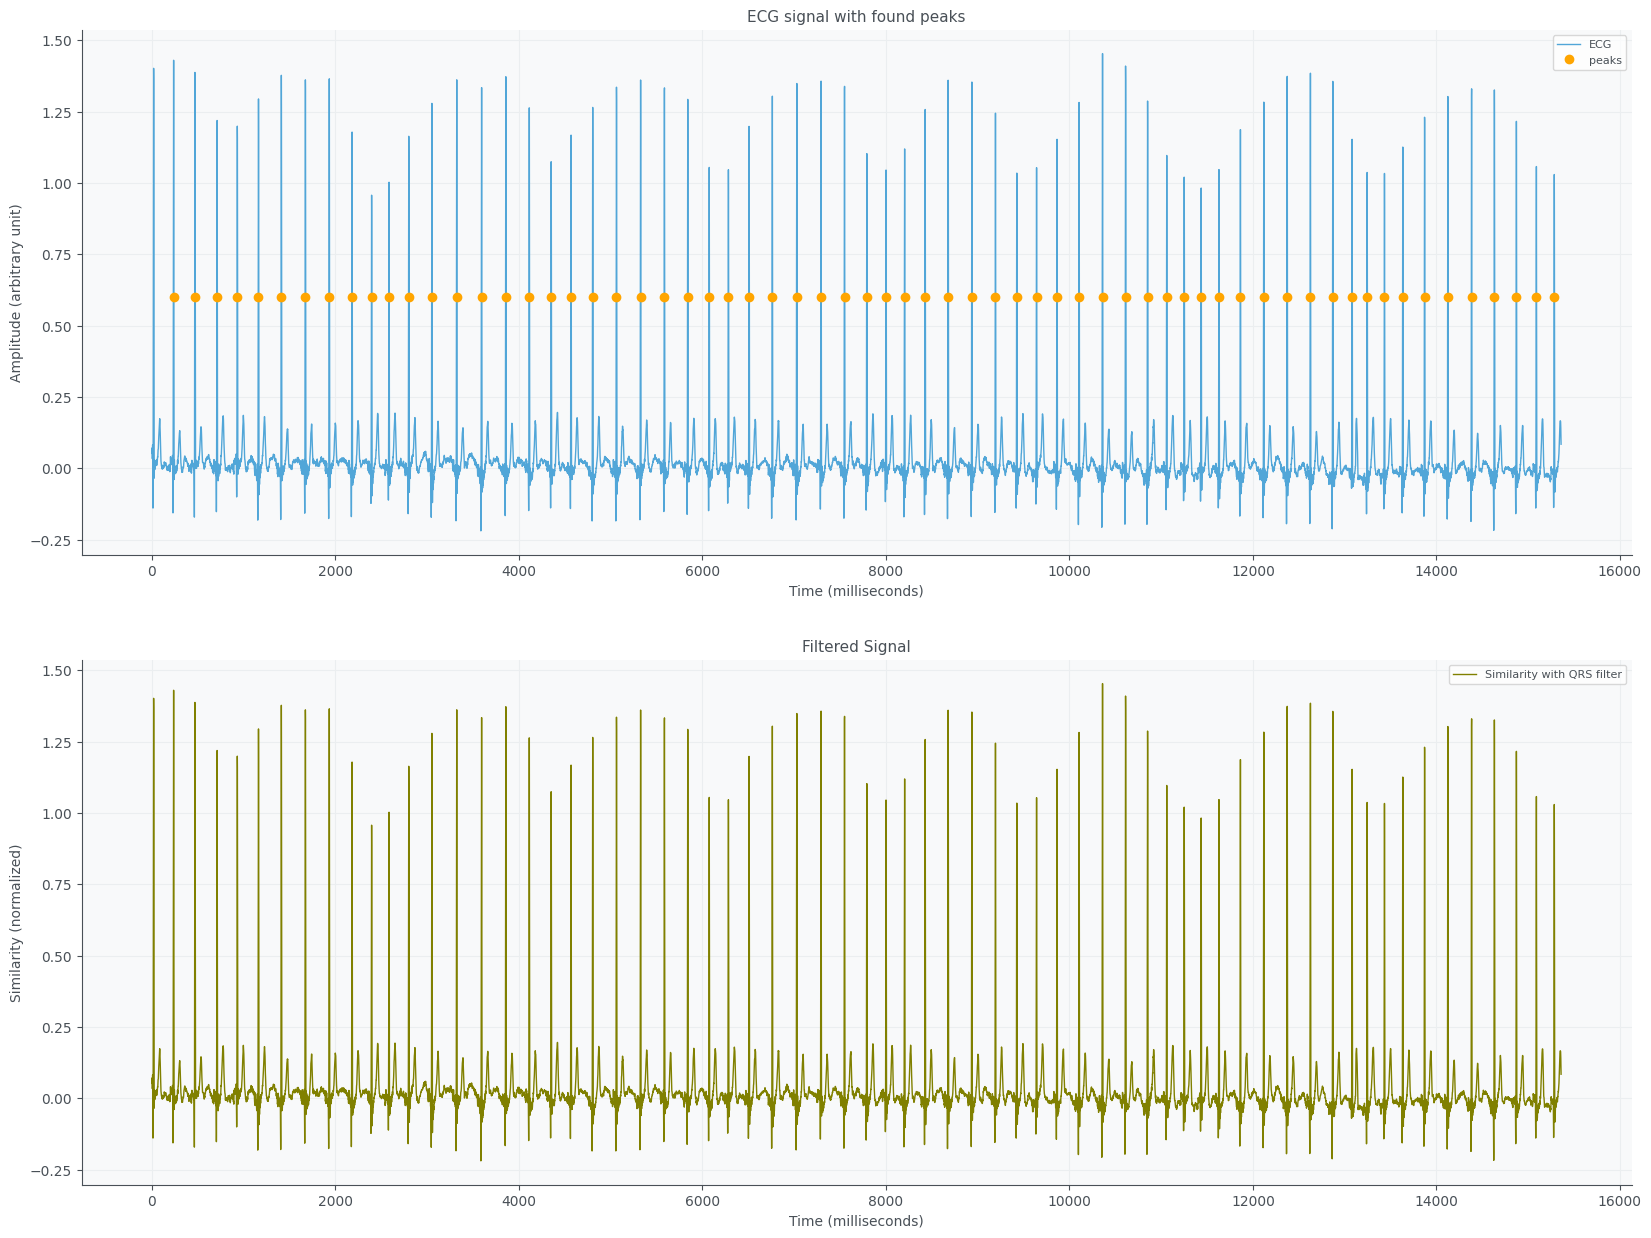

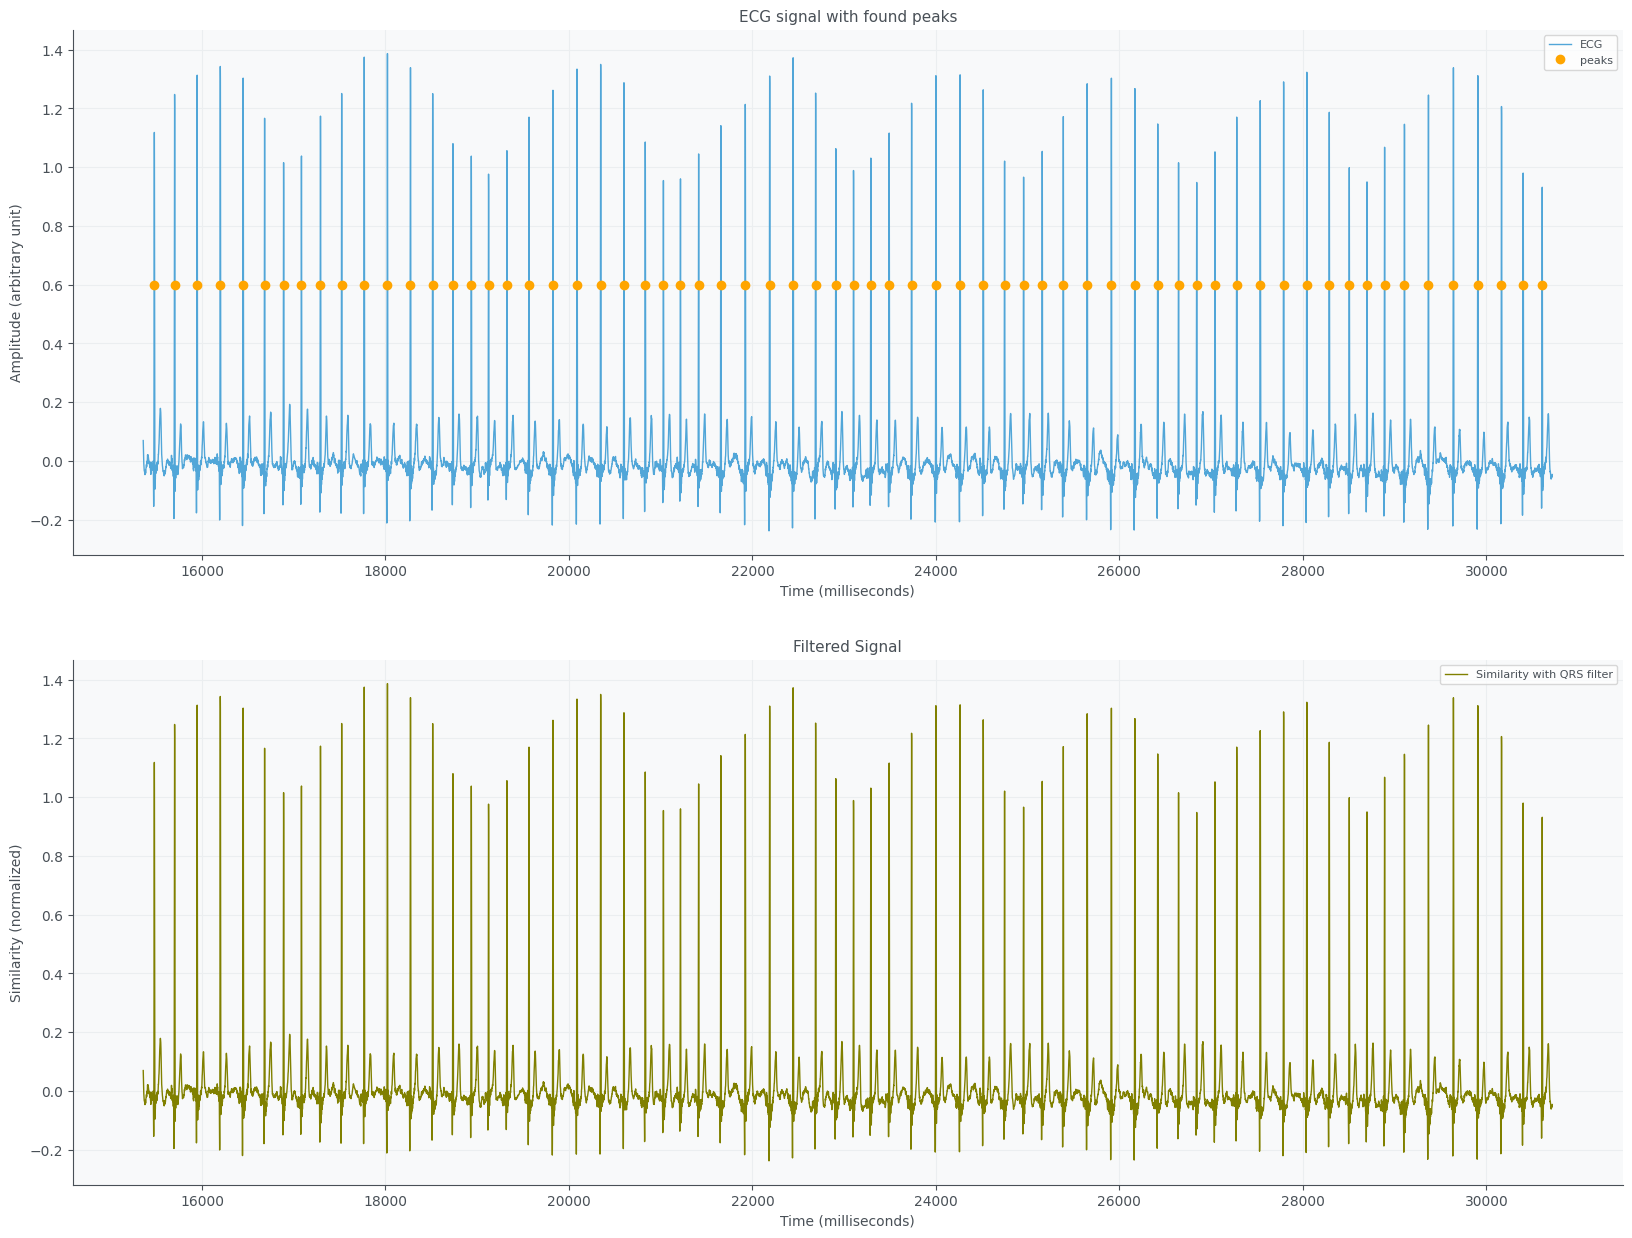

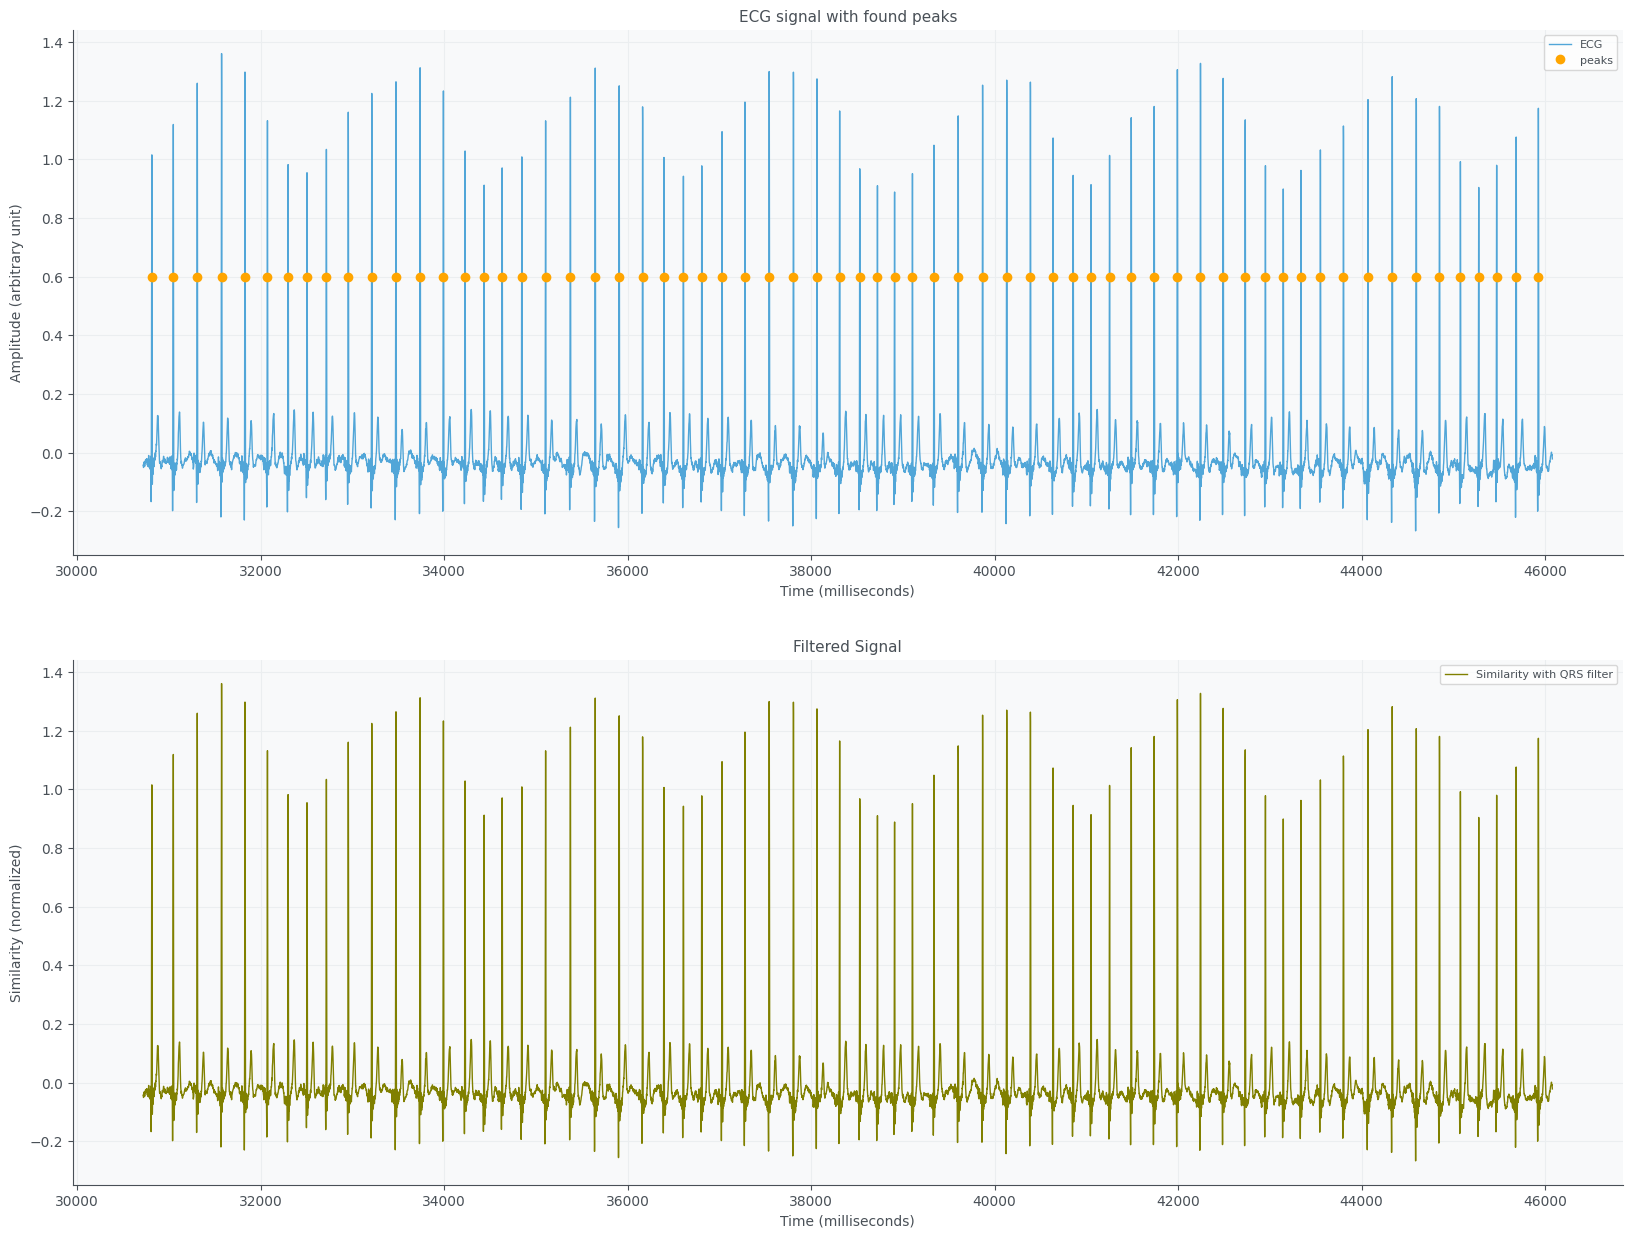

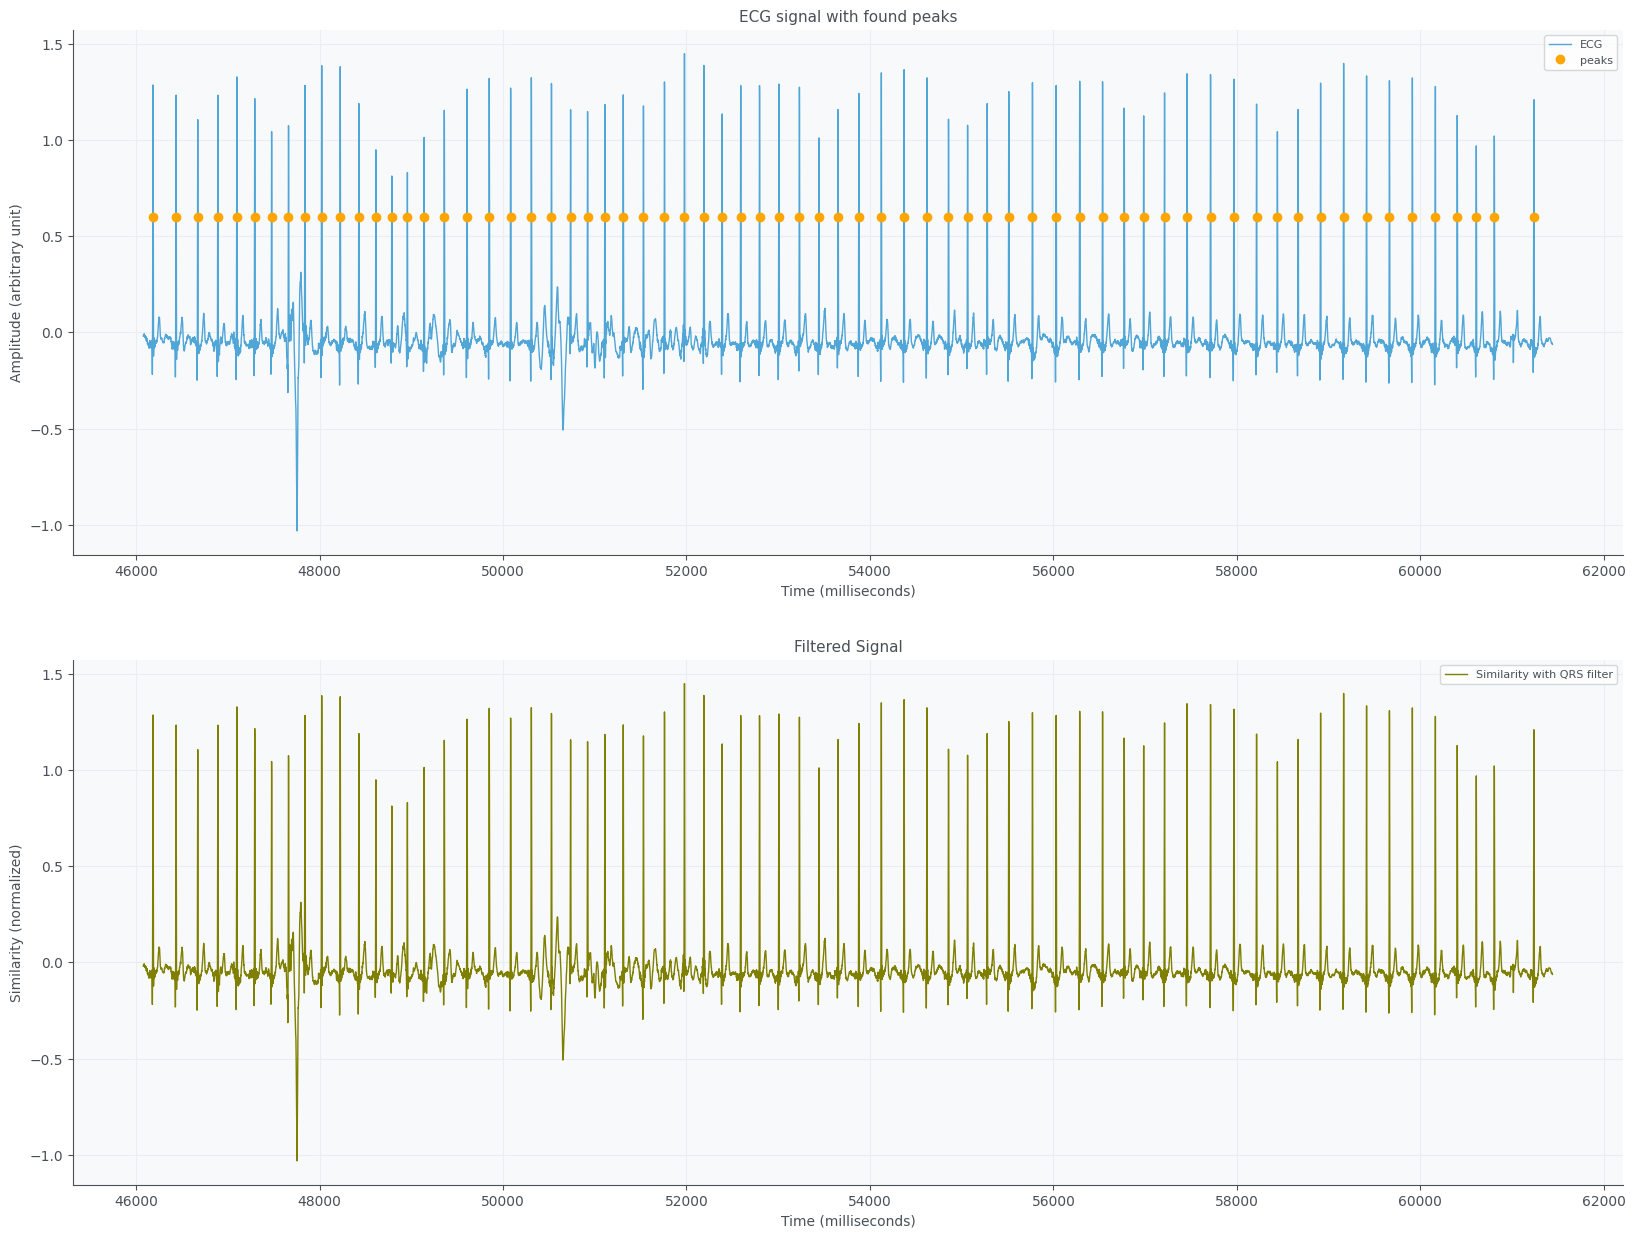

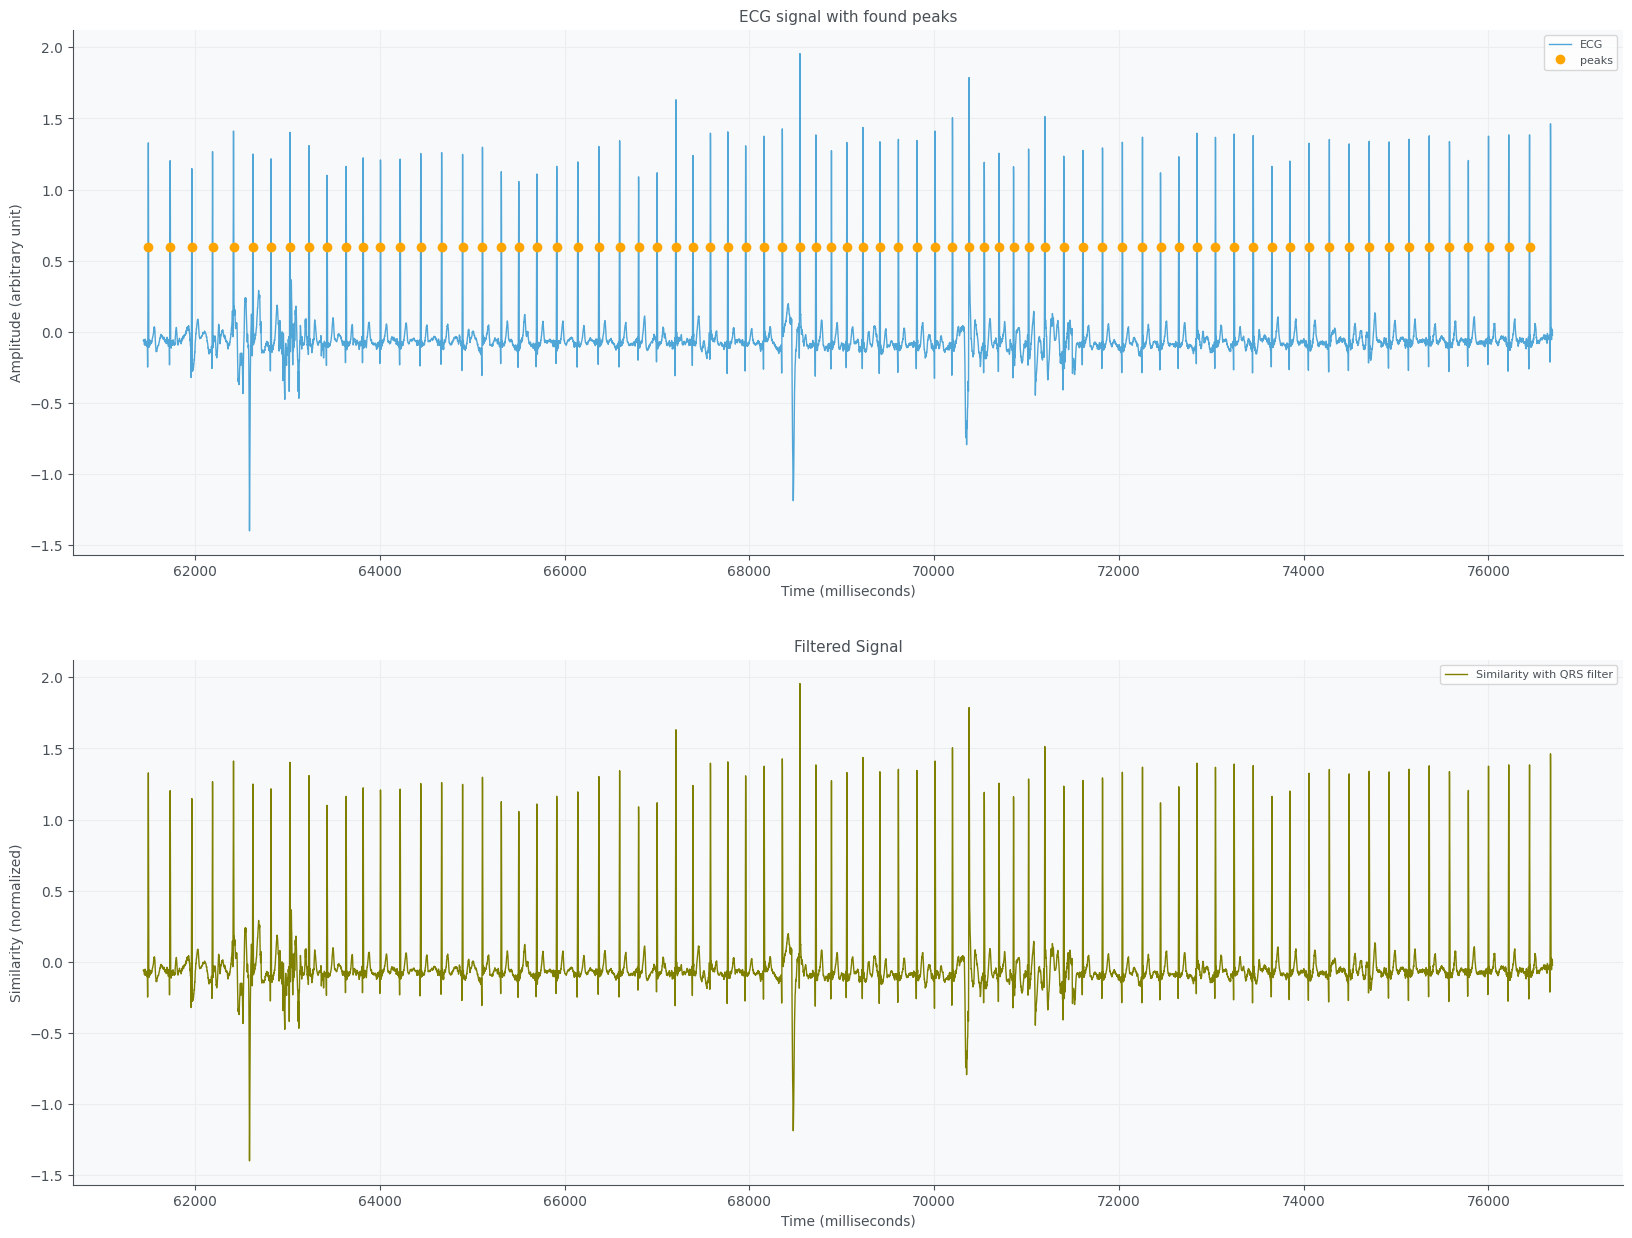

In [303]:
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
    r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]

    # detect peaks
    
    #peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(r_peaks_selected, np.repeat(0.6, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Filtered Signal')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(sliced_ecg_hrv, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

0
15360
15360
30720
30720
46080
46080
61440
61440
76800


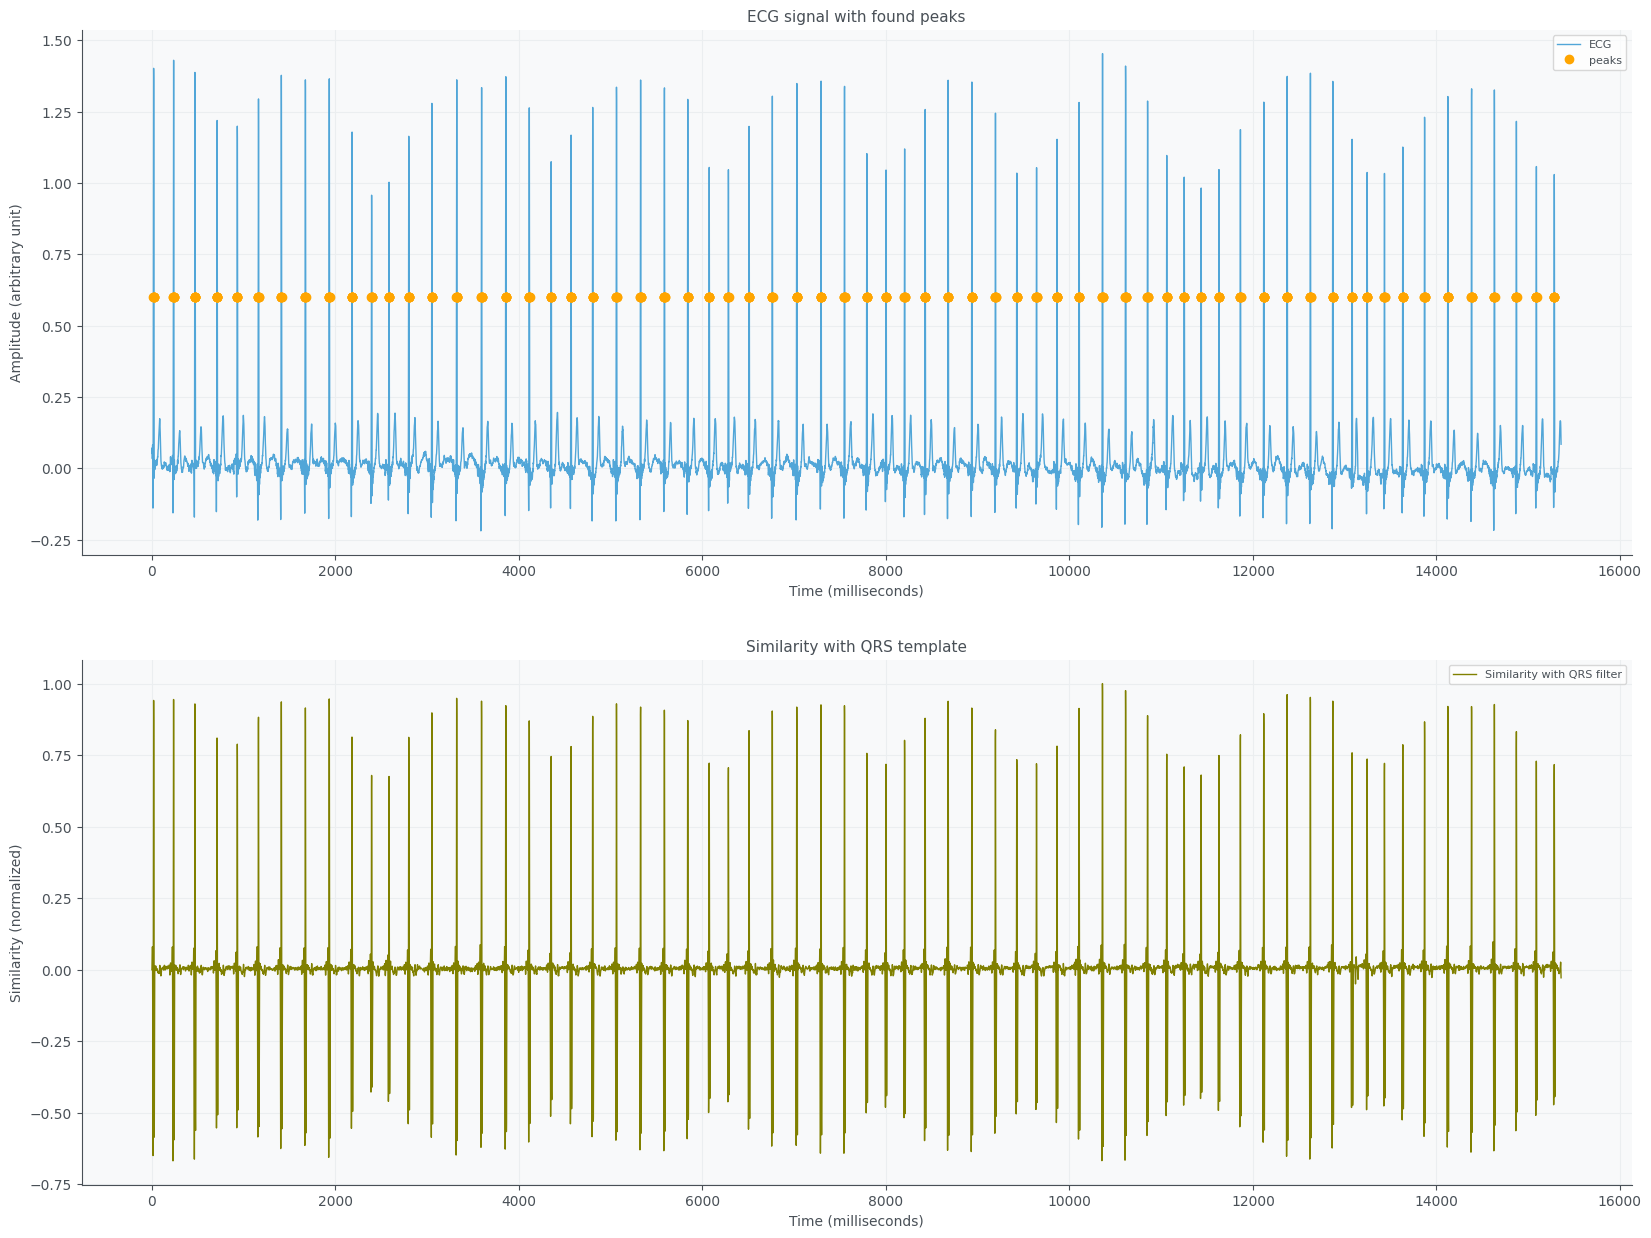

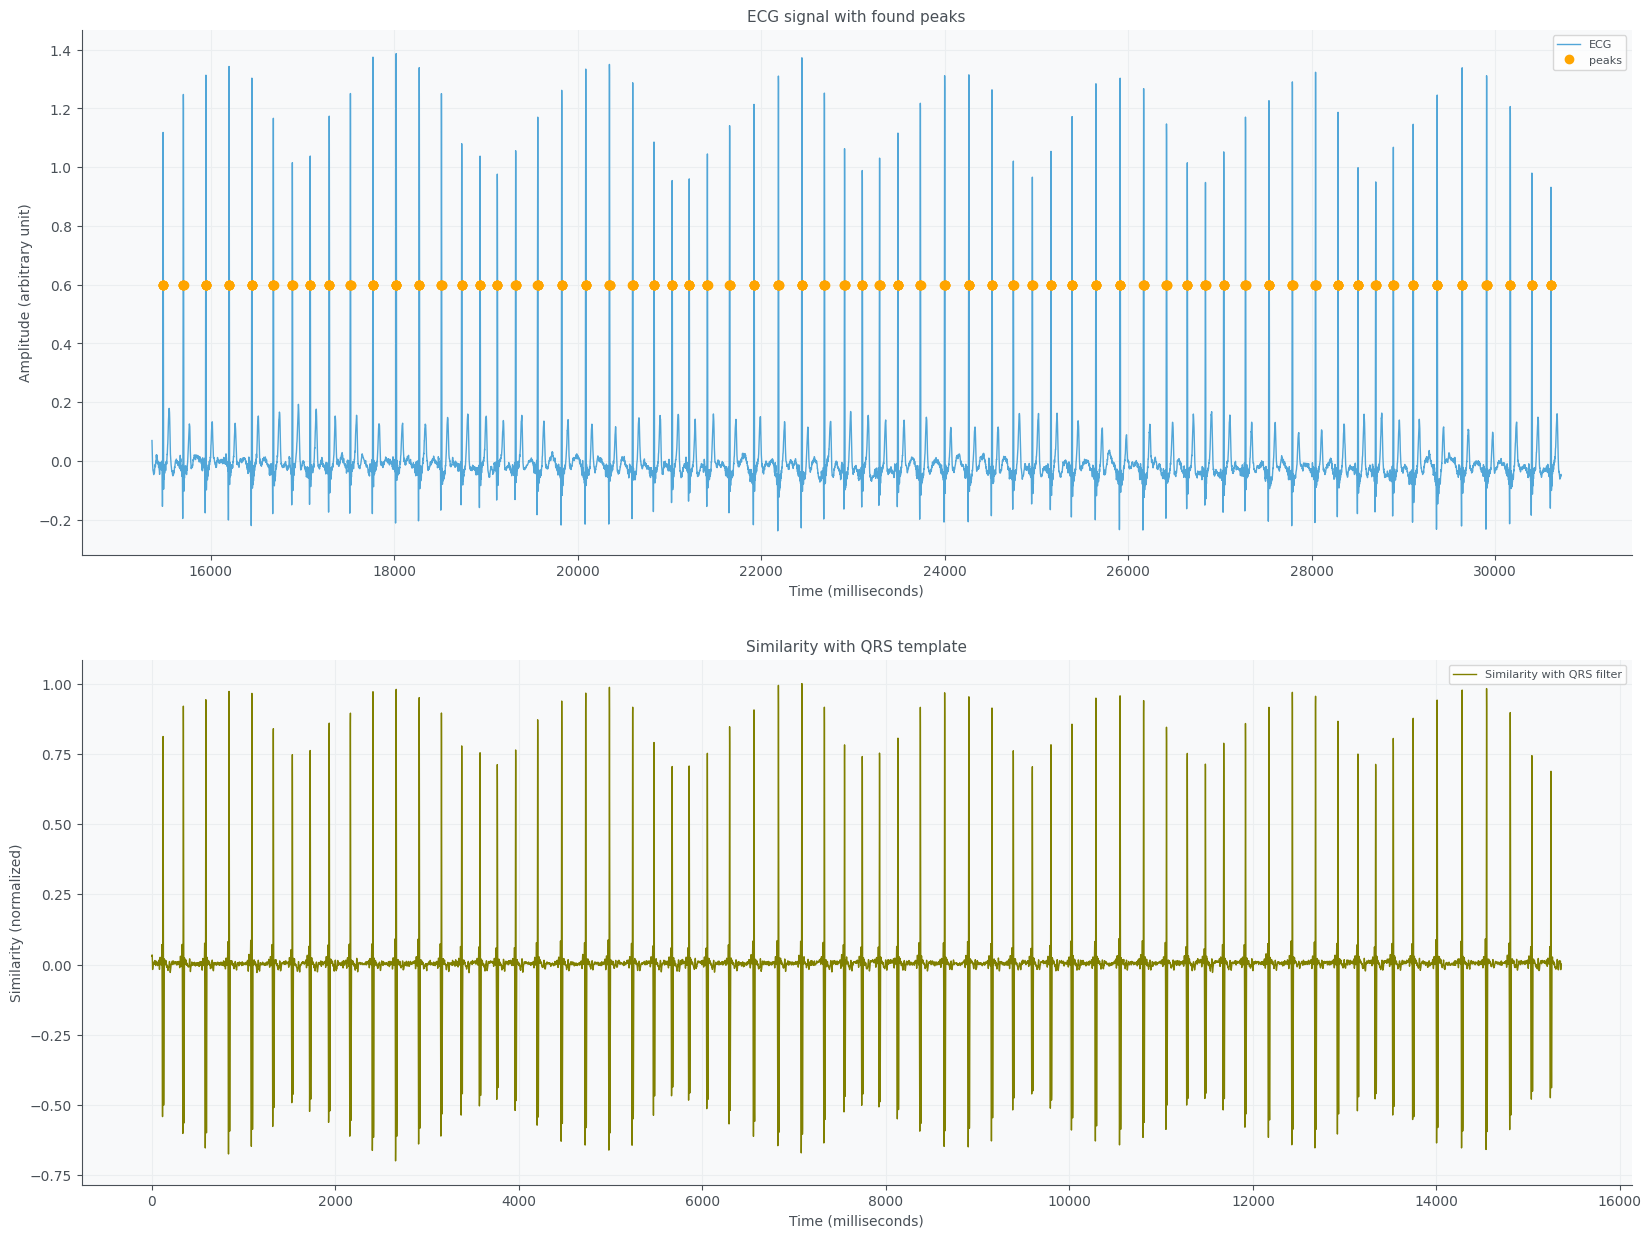

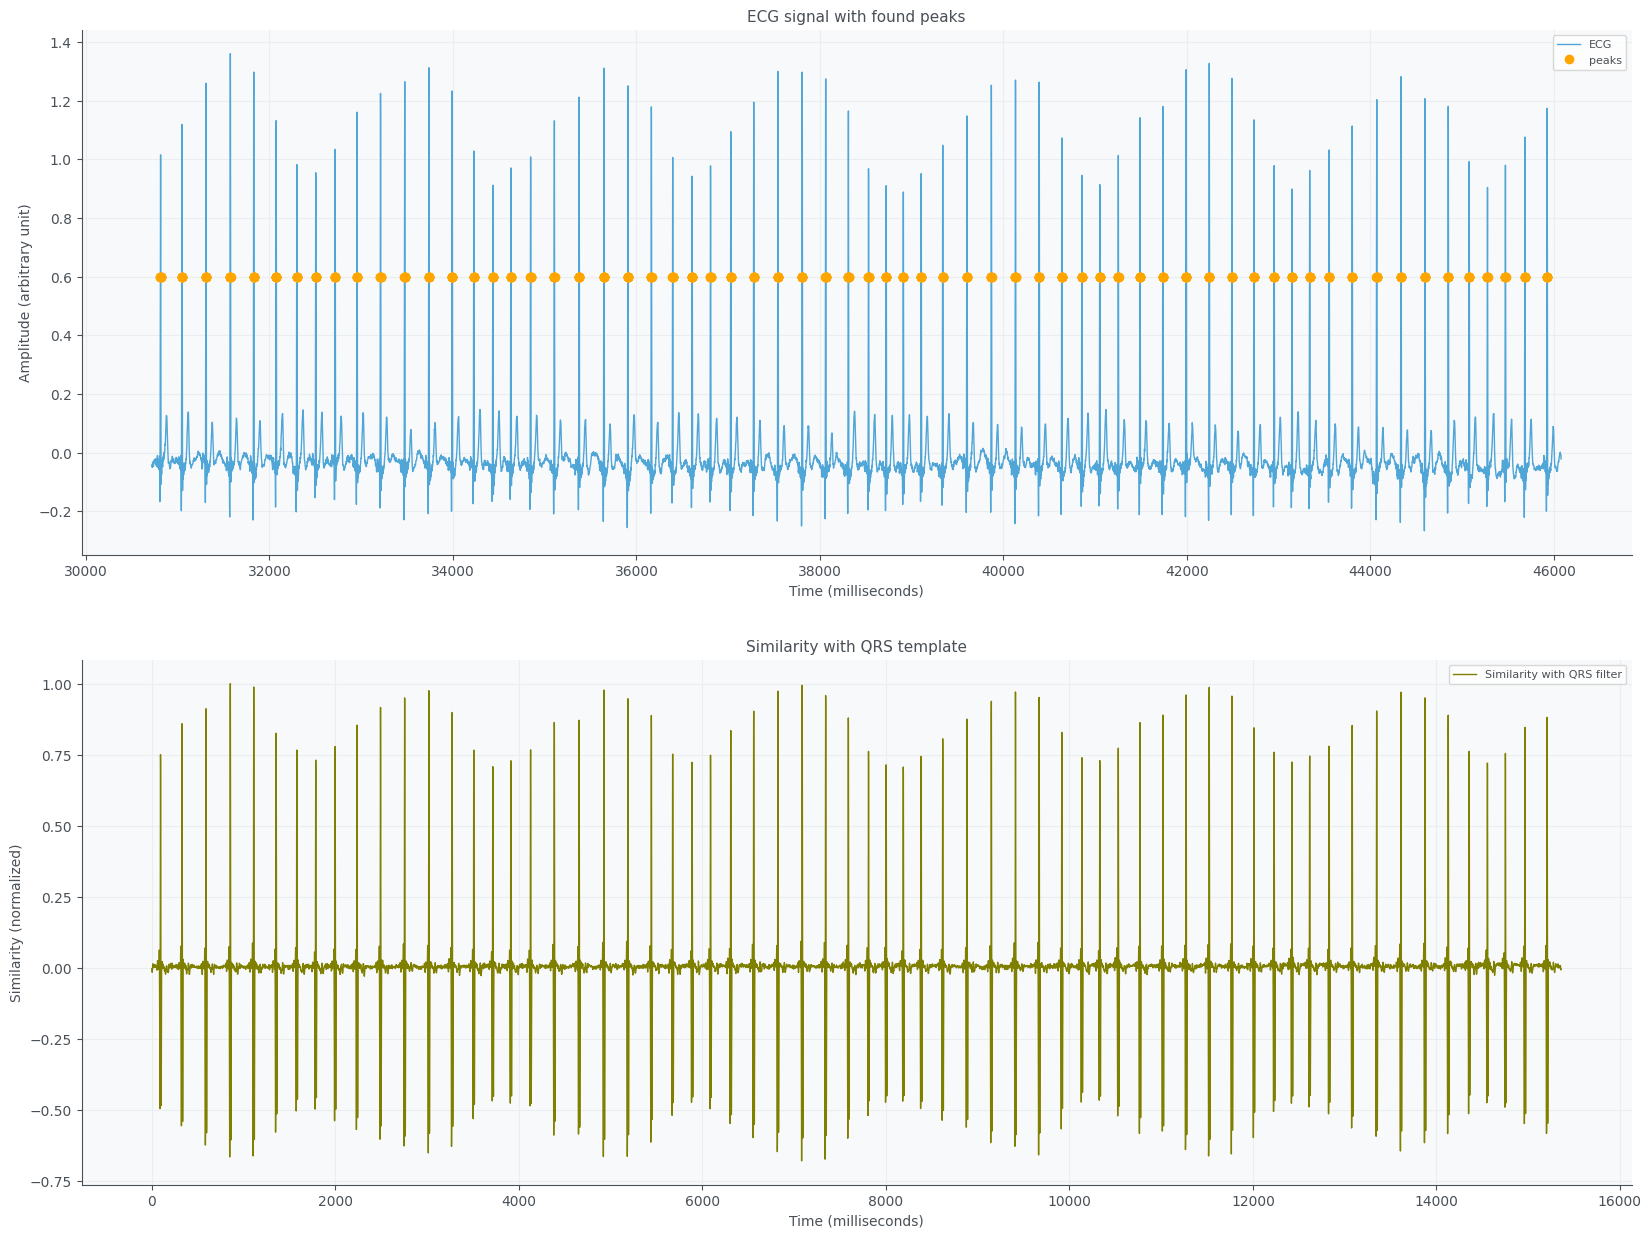

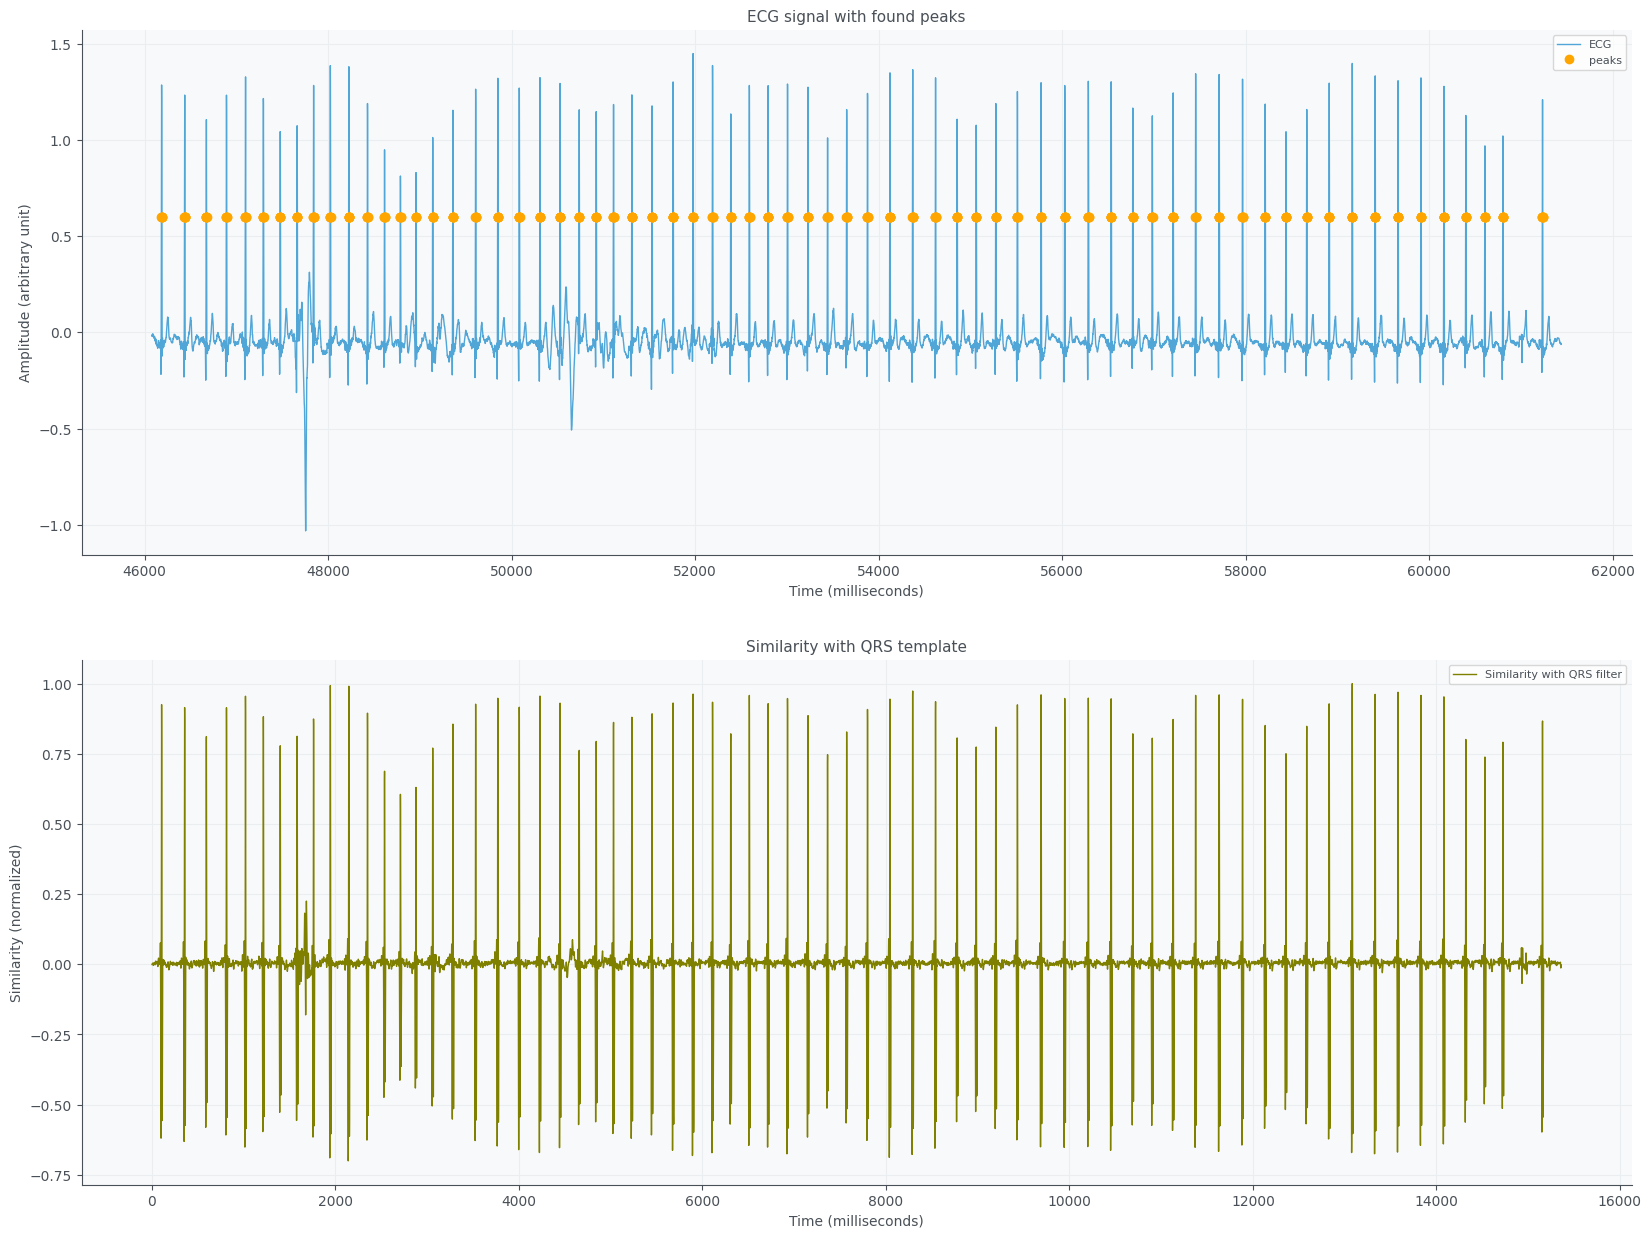

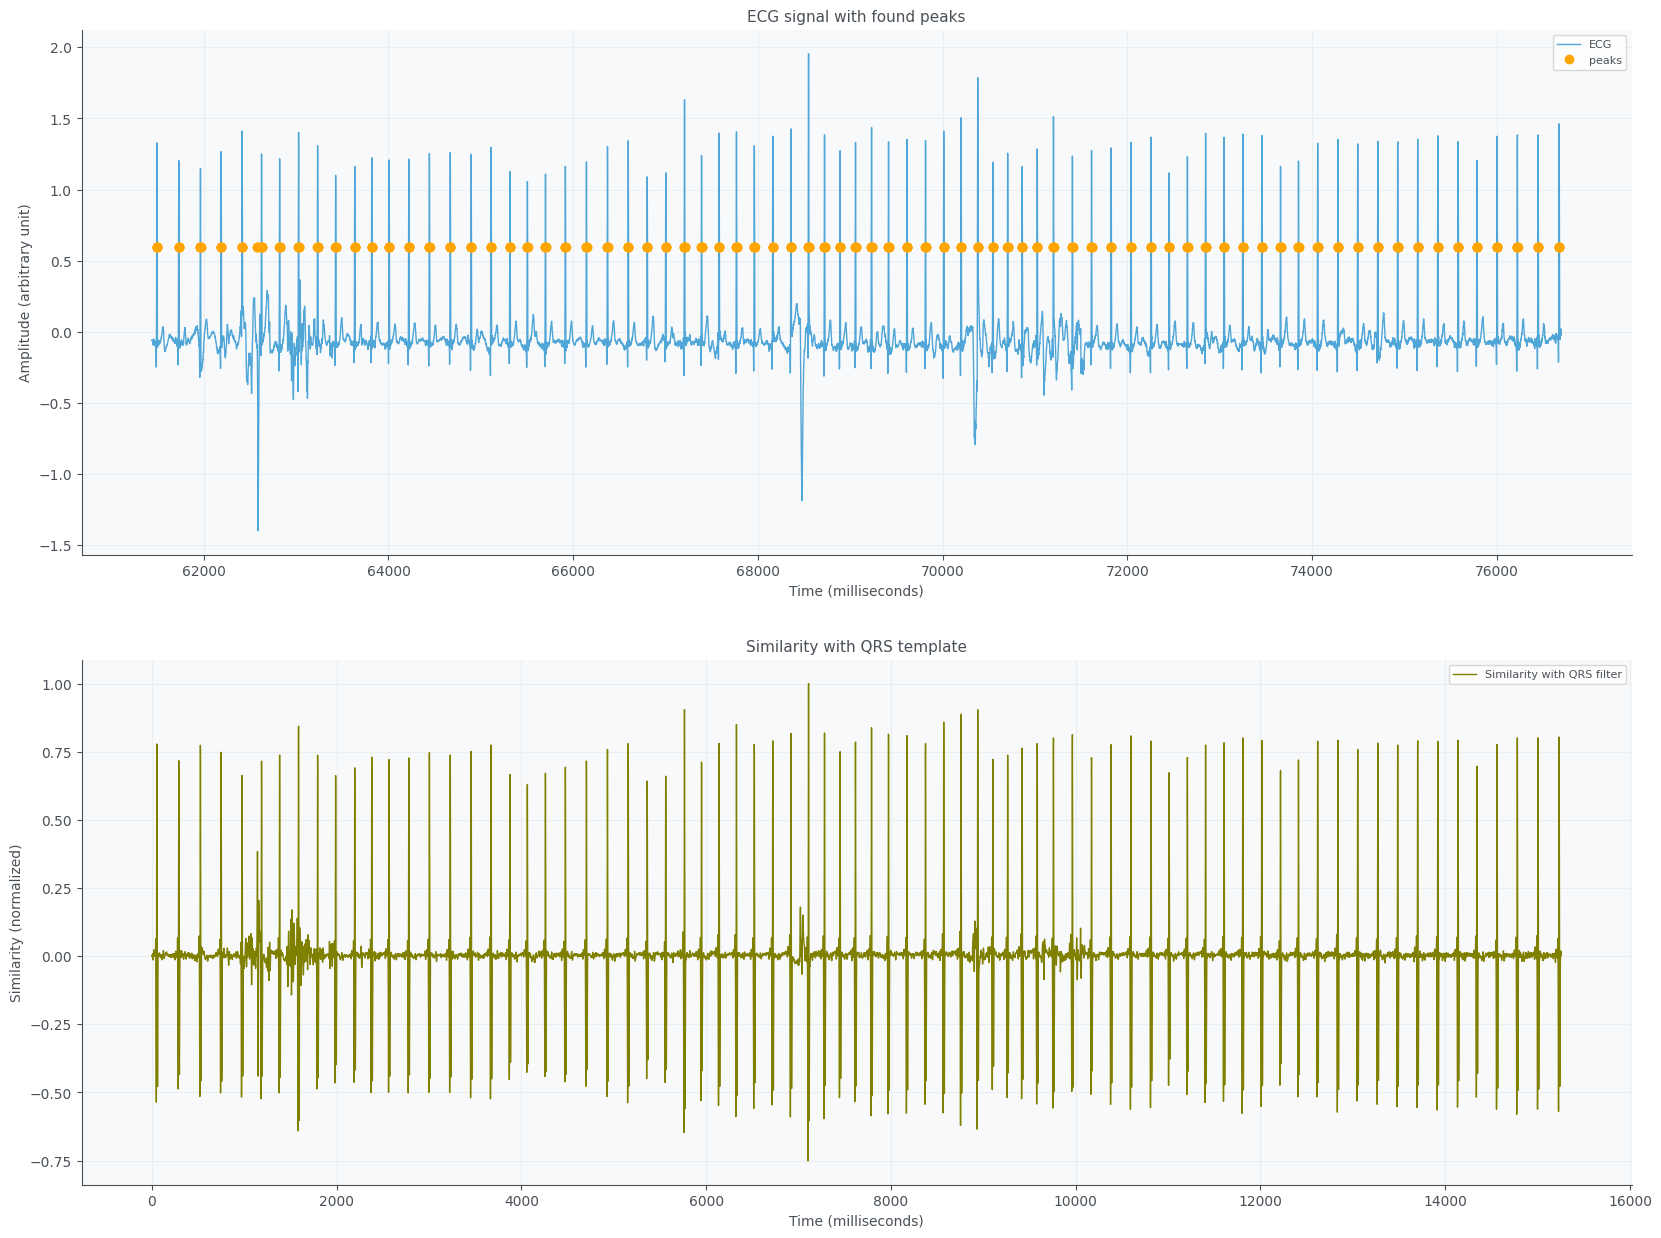

In [307]:
#starting_index_slcide_df= sliced_ecg_df.index[0]
#sampfrom = starting_index_slcide_df
#sampto = starting_index_slcide_df + 256*time_offset*60
#nr_plots = 5

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]

    # detect peaks
    
    peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(0.6, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    